# Feb 25th, 2022 (LFR reboot)

**Motivation**: Starting to look at LFR again.  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [2]:
fig_dir = pjoin(tmp_dir, 'fig_25th')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

ids

[0, 1, 2, 3, 4]

## $\pi$ plot

### Full

BOLD   : : :   ovp: 0.9943,  disj: 0.9816

Ca2    : : :   ovp: 0.9874,  disj: 0.9494

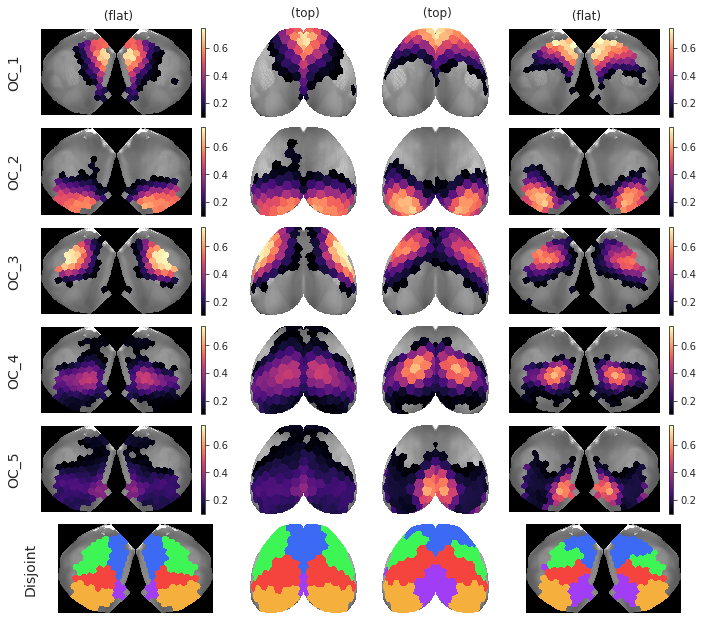

In [5]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('', ''),
    cmaps=('magma', 'magma'),
    min_thres=0.1,
    display=False,
)

ovp, disj = gr_bold.pi_symmetry_score(decimals=5)
print(f"BOLD   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5)
print(f"Ca2    : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

display(fig)

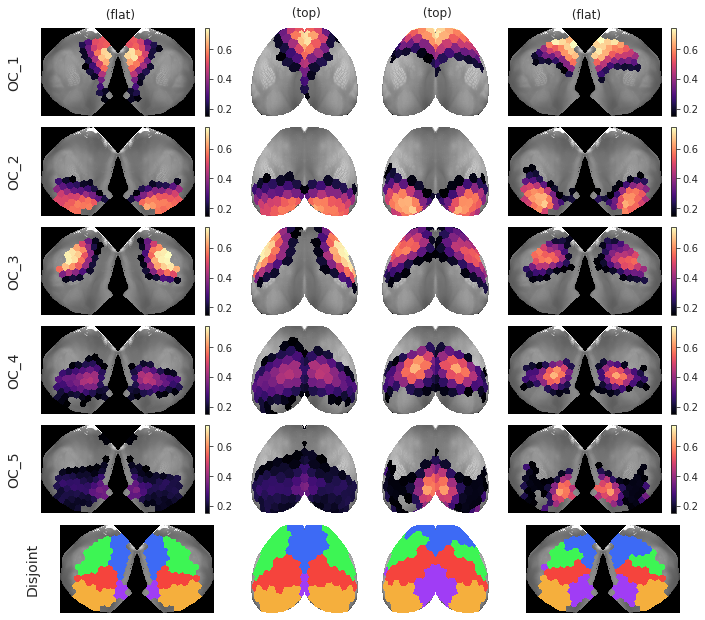

In [9]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('', ''),
    cmaps=('magma', 'magma'),
    min_thres=0.15,
    display=False,
)
display(fig)

### Pruned

BOLD   : : :   ovp: 0.9810,  disj: 0.9724

Ca2    : : :   ovp: 0.9652,  disj: 0.9402

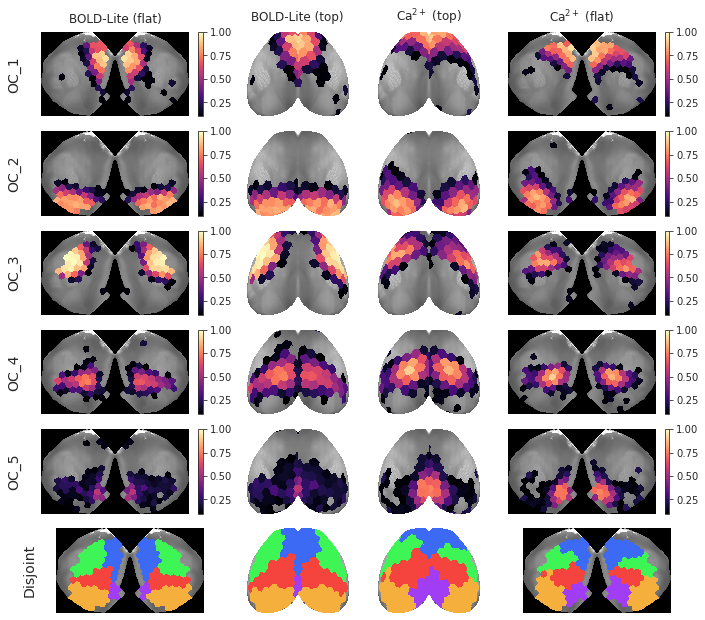

In [6]:
fig, _ = gr_ca.show(
    proj_1=gr_bold.project_vec(gr_bold.grp_pi_prune),
    proj_2=gr_ca.project_vec(gr_ca.grp_pi_prune),
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('magma', 'magma'),
    min_thres=0.10,
    display=False,
)
ovp, disj = gr_bold.pi_symmetry_score(gr_bold.grp_pi_prune, decimals=5)
print(f"BOLD   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(gr_ca.grp_pi_prune, decimals=5)
print(f"Ca2    : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

display(fig)

## LFR

### 1) load graphs

In [5]:
graphs_c = collect_graphs(mice, 'ca2')
graphs_b = collect_graphs(mice, 'bold-lite')

### 2) Choose params and mk lfr

In [6]:
# percent_ovp = np.arange(5, 96, 5)
# percent_ovp

In [7]:
mu = 0.1
num_nodes = len(gr_ca.n2l)
percent_ovp = np.arange(25, 76, 25)
ons = [
    int(np.round(p / 100 * num_nodes))
    for p in percent_ovp
]
ons = [0] + list(np.repeat(ons, 3))

oms = [0]
oms += [2, 3, 4] * (len(ons) - 1)

list(zip(ons, oms))

[
    (0, 0),
    (44, 2),
    (44, 3),
    (44, 4),
    (87, 2),
    (87, 3),
    (87, 4),
    (130, 2),
    (130, 3),
    (130, 4)
]

In [8]:
for on, om in zip(ons, oms):
    name = [
        f"on{on}",
        f"om{om}",
        f"mu{mu}",
    ]
    name = '-'.join(name)
    name = f"{name}_bold-lite"
    
    mk_lfr(
        name=name,
        lfr_dir=lfr_dir,
        graphs=graphs_b,
        on=on,
        om=om,
        mu=mu,
    )

### 3) First terminal step

```bash
./run_lfr.sh bo
```

### 4) Extract k (to be used by SVINET)

In [9]:
extract_true_k(lfr_dir)

### 5) Last terminal step

```bash
./loop_svinet_lfr.sh bo 100
```

## From ...-Copy1

### LFR Analysis

In [8]:
mu = 0.1
on, om = 44, 2
name = [
    f"on{on}",
    f"om{om}",
    f"mu{mu}",
]
name = '-'.join(name)
key = mice.get_key(8, 1, 1)
name = f"{name}_ca2_{key}"

lfr = load_lfr(
    load_dir=pjoin(lfr_dir, 'results', name),
    weighted=False,
    hierarchical=False,
    random_state=mice.cfg.random_state,
)

Num true communities:   7
Num overlapping nodes:  44

In [9]:
sorted_nodes = functools.reduce(operator.add, lfr['community'].values())

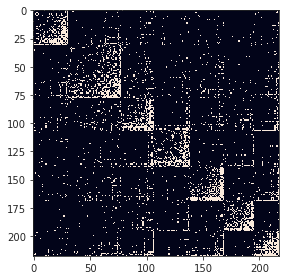

In [10]:
fig, ax = create_figure()
ax.imshow(lfr['a'][sorted_nodes][:, sorted_nodes])
plt.show()

In [11]:
lfr = compile_lfr_results(lfr_dir)

on87-om4-mu0.1_ca2_sub-SLC10_ses-3_run-7: 100%|██████████| 1180/1180 [01:29<00:00, 13.13it/s]


In [12]:
list(lfr)

[
    'on0-om0-mu0.1',
    'on44-om2-mu0.1',
    'on44-om3-mu0.1',
    'on44-om4-mu0.1',
    'on87-om2-mu0.1',
    'on87-om3-mu0.1',
    'on87-om4-mu0.1',
    'on130-om2-mu0.1',
    'on130-om3-mu0.1',
    'on130-om4-mu0.1'
]

In [13]:
x = lfr['on0-om0-mu0.1']['ca2_sub-SLC02_ses-1_run-7'].copy()
x.shape

(10, 4, 174)

In [14]:
x_mean = x.mean(0)

In [15]:
sim_avg = np.zeros(len(x))
for i in range(10):
    sim = dist2sim(sp_dist.cdist(x_mean, x[i], 'cosine'))
    sim_avg[i] = np.diag(sim).mean()

In [16]:
sim_avg

array([0.99899574, 0.99793649, 0.99928778, 0.99802988, 0.99791941,
       0.99928295, 0.9991501 , 0.99789118, 0.99433733, 0.99727905])

<matplotlib.image.AxesImage object at 0x7fbc39776ca0>

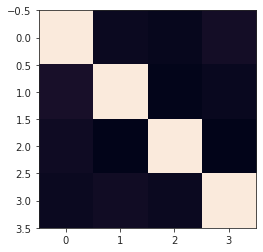

In [17]:
plt.imshow(sim)

In [18]:
pi = x / x.sum(1, keepdims=True)
pi_avg = pi.mean(0)
pi.shape, pi_avg.shape

((10, 4, 174), (4, 174))

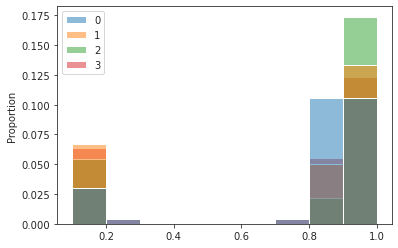

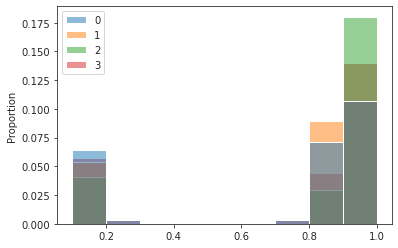

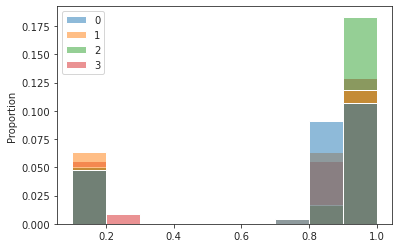

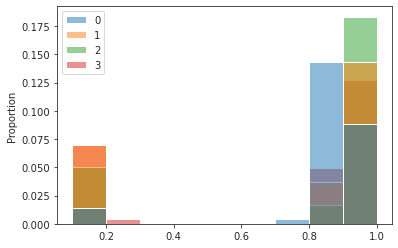

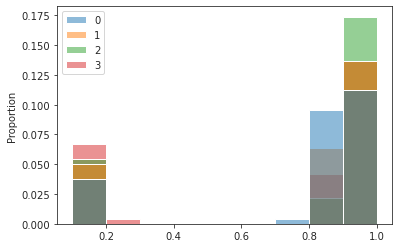

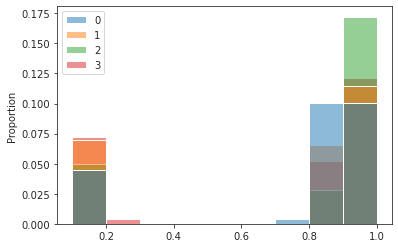

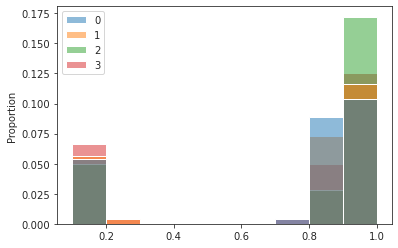

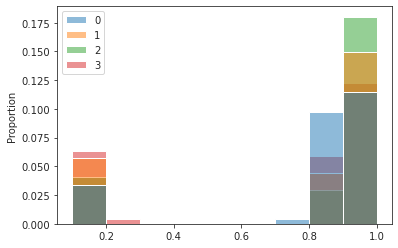

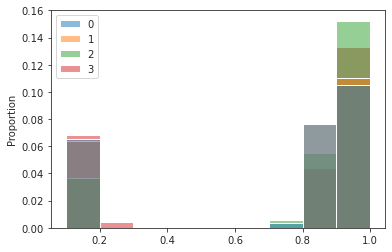

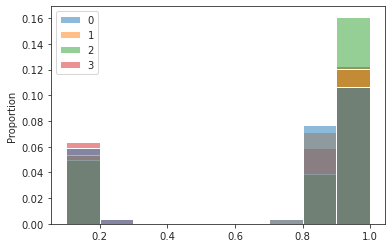

In [19]:
bins = np.linspace(0.1, 1.0, 10)
for i in range(10):
    sns.histplot(pi[i].T, bins=bins, stat='proportion')
    plt.show()

In [20]:
pi.shape

(10, 4, 174)

In [21]:
np.round(pi, 2)

array([[[0.82, 0.17, 0.99, ..., 0.9 , 0.88, 0.91],
        [0.  , 0.  , 0.  , ..., 0.  , 0.07, 0.03],
        [0.  , 0.83, 0.  , ..., 0.  , 0.05, 0.06],
        [0.18, 0.  , 0.  , ..., 0.1 , 0.  , 0.  ]],

       [[0.82, 0.  , 0.99, ..., 0.9 , 0.95, 0.93],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.99, 0.  , ..., 0.  , 0.05, 0.07],
        [0.17, 0.  , 0.  , ..., 0.1 , 0.  , 0.  ]],

       [[0.82, 0.  , 0.99, ..., 0.9 , 0.95, 0.92],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.01],
        [0.  , 0.99, 0.  , ..., 0.  , 0.05, 0.07],
        [0.17, 0.  , 0.  , ..., 0.1 , 0.  , 0.  ]],

       ...,

       [[0.82, 0.  , 0.99, ..., 0.99, 0.88, 0.89],
        [0.  , 0.  , 0.  , ..., 0.  , 0.07, 0.04],
        [0.  , 0.99, 0.  , ..., 0.  , 0.05, 0.07],
        [0.17, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]],

       [[0.82, 0.17, 0.99, ..., 0.9 , 0.99, 0.97],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.03],
        [0.  , 0.82, 0.  , ..., 0.  , 0.  , 0.  ],
        [0.17, 0.  , 0.  , ..., 0.1 , 0.  , 0.  ]],

       [[0.82, 0.17, 0.99, ..., 0.89, 0.99, 0.93],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.82, 0.  , ..., 0.  , 0.  , 0.06],
        [0.18, 0.  , 0.  , ..., 0.1 , 0.  , 0.  ]]])

In [22]:
booted = bootstrap(
    x=pi,
    n_resamples=10000,
    batch=5,
    dims={'seed': 10},
)
booted.shape

(10000, 10, 4, 174)

In [23]:
pi.shape

(10, 4, 174)

In [24]:
booted_avg = booted.mean(1)
booted_avg.shape

(10000, 4, 174)

In [25]:
where = list(zip(*np.where(pi_avg < 0.2)))

In [26]:
where[55]

(0, 72)

In [27]:
pi_avg[0, 72]

0.07145931171937858

In [28]:
booted_avg[:, 0, 72].mean()

0.07147995339882744

<AxesSubplot:ylabel='Count'>

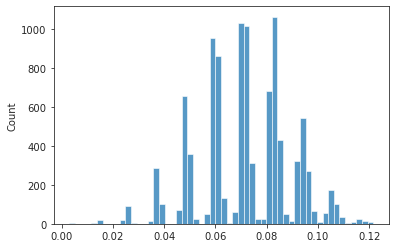

In [29]:
sns.histplot(booted_avg[:, 0, 72])

In [30]:
booted_avg[:, 0, 73].mean()

0.9914285601062854

In [31]:
se_boot = np.std(booted_avg, 0, ddof=1)

<matplotlib.image.AxesImage object at 0x7fbc285098b0>

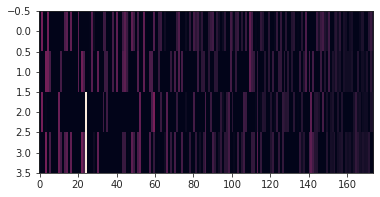

In [32]:
plt.imshow(se_boot, aspect=21)

In [33]:
ci = 0.99
dof = 10 - 1
t_val = sp_stats.t.ppf(ci, dof)

In [34]:
prune_matrix = pi_avg - t_val * se_boot
prune_matrix = prune_matrix < 0.02

In [35]:
prune_matrix.sum()

452

In [36]:
pi_prune = dc(pi)
for i in range(10):
    pi_prune[i][prune_matrix] = 0.
pi_prune /= pi_prune.sum(1, keepdims=True)
pi_prune_avg = pi_prune.mean(0)

In [41]:
thres = 0.15
x = (pi_prune_avg >= thres).sum(0) - 1
ovp = collections.Counter(x)
ovp = {s + 1: ovp.get(s, 0) for s in range(8)}
ovp = {
    s: np.round(100 * c / sum(ovp.values()))
    for s, c in ovp.items()
}

In [42]:
ovp

{1: 94.0, 2: 6.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0}

In [43]:
ci = 0.99
dof = 10 - 1
t_val = sp_stats.t.ppf(ci, dof)

In [44]:
dlist = []
for lfr_name, results in tqdm(lfr.items()):
    on, om, mi = map(
        lambda s: int(re.findall(r'\d+', s)[0]),
        lfr_name.split('-')
    )
    for k, gam in results.items():
        pi = gam / gam.sum(1, keepdims=True)
        booted = bootstrap(
            x=pi,
            n_resamples=10000,
            batch=5,
            dims={'seed': len(pi)},
        )
        booted = booted.mean(1)
        se_boot = np.std(booted, 0, ddof=1)

        prune_matrix = pi.mean(0) - t_val * se_boot
        prune_matrix = prune_matrix < 0.02

        pi_prune = dc(pi)
        for i in range(len(pi)):
            pi_prune[i][prune_matrix] = 0.
        pi_prune /= pi_prune.sum(1, keepdims=True)
        
        for thres in [0.05, 0.1, 0.15, 0.2, 0.25]:
            x = (pi_prune.mean(0) >= thres).sum(0) - 1
            ovp = collections.Counter(x)
            ovp = {s + 1: ovp.get(s, 0) for s in range(8)}
            ovp = {
                s: np.round(100 * c / sum(ovp.values()))
                for s, c in ovp.items()
            }
            dlist.append({
                'thres': [thres] * len(ovp),
                'mi': [mi] * len(ovp),
                'on': [on] * len(ovp),
                'om': [om] * len(ovp),
                'k': [k] * len(ovp),
                'score': ovp.keys(),
                'proportion': ovp.values(),
            })   
df = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/10 [00:00<?, ?it/s]

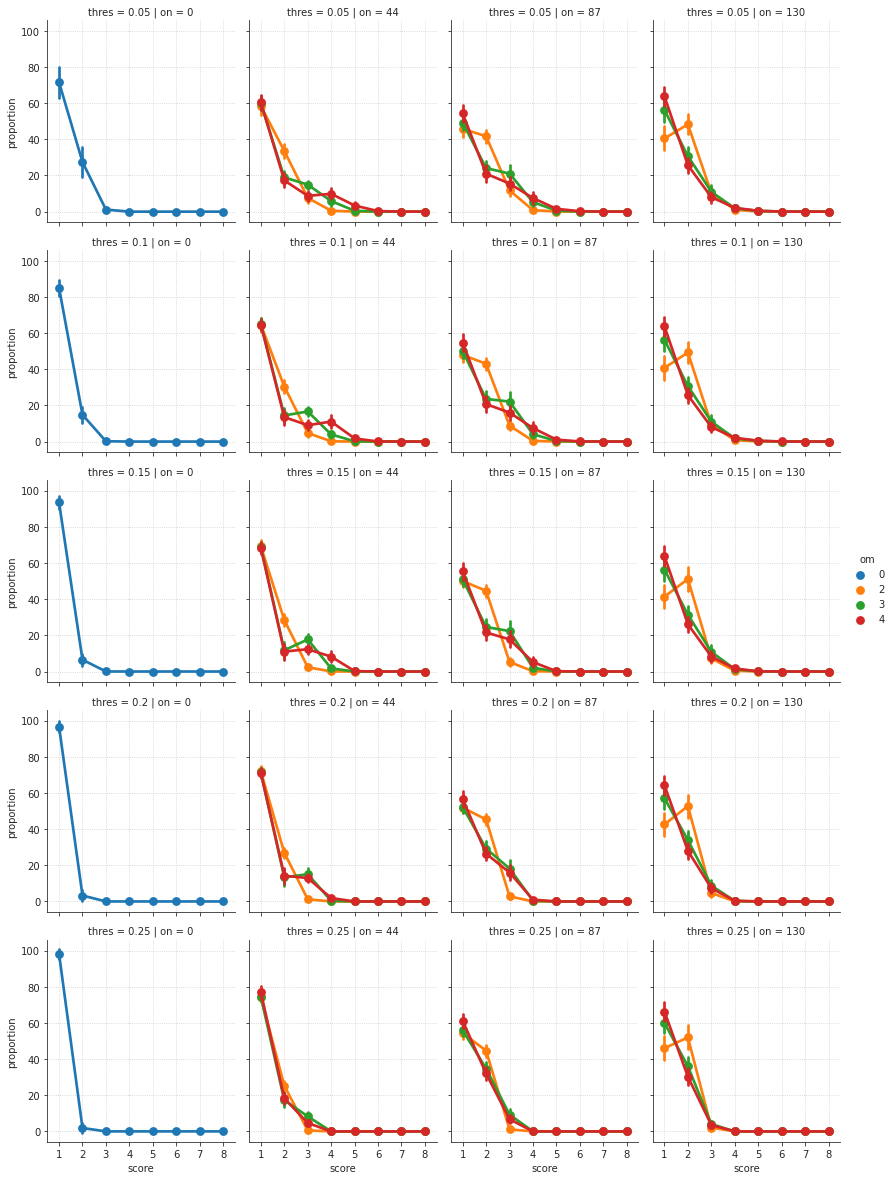

In [45]:
fg = sns.catplot(
    data=df,
    x='score',
    y='proportion',
    hue='om',
    col='on',
    row='thres',
    kind='point',
    ci='sd',
    aspect=0.9,
    height=3.3,
)
add_grid(fg.axes)
plt.show()

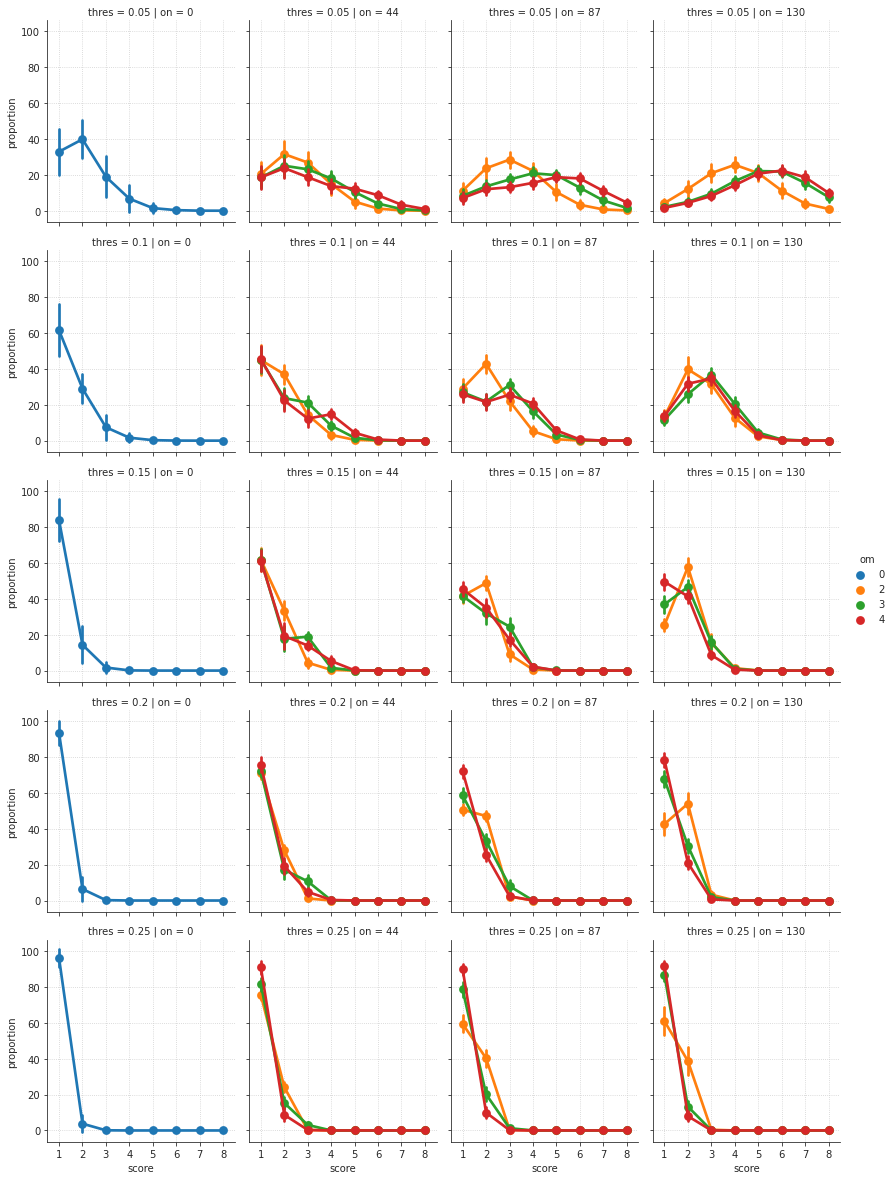

In [61]:
df_mean = df.groupby(['thres', 'on', 'om', 'score']).mean()[['proportion']]
df_mean.reset_index(inplace=True)

In [62]:
df_mean

,thres,on,om,score,proportion
0,0.05,0,0,1,71.550847
1,0.05,0,0,2,27.432203
2,0.05,0,0,3,1.127119
3,0.05,0,0,4,0.000000
4,0.05,0,0,5,0.000000
...,...,...,...,...,...
395,0.25,130,4,4,0.000000
396,0.25,130,4,5,0.000000
397,0.25,130,4,6,0.000000
398,0.25,130,4,7,0.000000


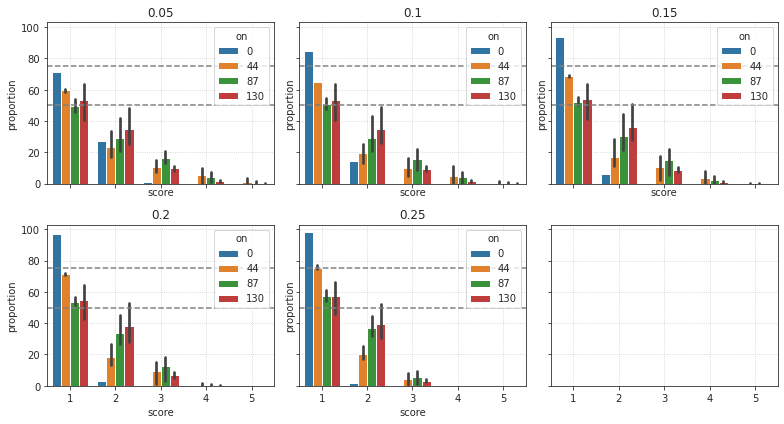

In [72]:
fig, axes = create_figure(2, 3, (11, 6), 'all', 'all')
for i, th in enumerate(df_mean['thres'].unique()):
    ax = axes.flat[i]
    _df = df_mean.loc[
        (df_mean['thres'] == th) &
        (df_mean['score'].isin(range(1, 6)))
    ]
    sns.barplot(
        data=_df,
        x='score',
        y='proportion',
        hue='on',
        ax=ax,
    )
    ax.set_title(th)
    ax.axhline(50, color='grey', ls='--')
    ax.axhline(75, color='grey', ls='--')
add_grid(axes)
plt.show()

## Ignore below

In [12]:
key = 'sub-SLC01_ses-2_run-7'
g = graphs_c[key]

In [23]:
a = nx.adjacency_matrix(g).toarray()

<matplotlib.image.AxesImage object at 0x7fa8bb188f10>

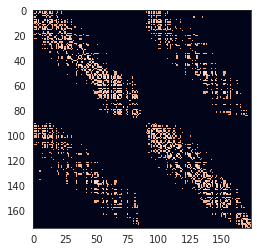

In [24]:
plt.imshow(a)

In [25]:
np.abs(a).sum(0)

array([ 2.46529264, 13.9305836 , 16.71363035,  0.85549579, 14.07862175,
        7.30401444,  0.        , 21.83913394, 14.03365681, 24.42202542,
        6.59528037, 19.82852641, 10.65203618, 18.05437283, 21.83744293,
       22.51737441,  4.93027312,  4.09800633, 24.32993298,  7.44213521,
       28.01995707,  5.01320358, 25.21627917, 17.99568565,  6.7417913 ,
       13.91787461, 13.89860807, 29.71081643, 19.36875361, 10.83015432,
       18.00243609,  4.2686621 ,  2.43594671,  4.15119151, 21.38226153,
        3.41208519, 11.7599881 , 14.38777567, 20.601204  ,  7.52614532,
        6.56637531,  6.08927462, 22.67304722, 19.51346203, 18.33336706,
       11.01186497, 12.34137697, 10.91719319,  7.48739089, 22.89162846,
       16.97829072, 28.50305049, 22.32726903, 16.24503661, 18.75770035,
       10.70669397, 25.39807246, 13.46085094, 18.58132806, 22.73209679,
       16.26690058,  0.        , 16.99838489,  3.27824539, 14.63419122,
       30.13342124, 17.76062292, 17.14808422, 17.05152751, 19.23329998,
       19.22400179,  0.        ,  2.52283813,  0.        ,  5.70097288,
       17.59391422,  0.        ,  4.07175768,  0.        , 16.23284863,
        8.16007265, 13.70402209, 12.39200284, 11.42846914,  3.16088919,
        1.62151747,  0.        ,  0.        ,  0.        ,  0.        ,
        4.04095752,  2.38891463, 15.67798264,  0.        , 24.25775038,
        4.85729352, 18.36417863, 12.30329604, 17.61668022, 13.26083843,
       24.24720883, 27.78874939, 14.86325978,  2.32845745,  9.7576696 ,
       23.68845752, 11.76309317, 29.88867828, 15.93096859, 24.21628668,
        9.11762248, 10.65529199,  9.94924583, 16.63640694, 21.07788791,
       14.13953276, 10.97629979, 15.51505735,  5.09968643,  7.4902122 ,
        0.        , 20.51669553,  0.        , 18.3942985 , 19.21894561,
       16.37787602,  7.66460385, 12.36778416,  7.42938078, 21.72966436,
       18.53077749, 27.55861626, 17.19114095, 12.65466181,  9.15603635,
        4.00430657, 26.22042036, 19.72439409, 27.59909775, 19.96170442,
       12.79487747, 10.84748031, 12.44541182, 26.39696186,  0.        ,
       18.96368306, 21.85890292, 15.91160263,  0.        , 12.53927119,
        8.91635389,  5.69900346, 23.77065072, 18.63290383, 12.55265382,
       17.33830798,  7.33416223, 25.41387044,  0.        ,  1.57287339,
        0.        ,  0.79312802, 15.65256332, 11.95432152,  6.46148447,
        5.60260507,  8.97522475,  5.77460509,  8.16782923,  5.74674788,
        9.07319468,  7.30789615,  4.12966342,  3.15552394])

[<matplotlib.lines.Line2D object at 0x7fa8bb4c48b0>]

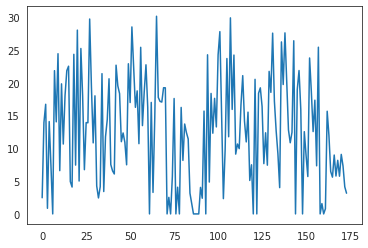

In [26]:
plt.plot(np.abs(a).sum(0))

In [28]:
key

'sub-SLC01_ses-2_run-7'

In [34]:
np.array_equal(np.isnan(gr_ca.run_deg[0, 1, 3]), np.abs(a).sum(0) == 0)

True

In [40]:
key = 'sub-SLC04_ses-2_run-7'
g = graphs_b[key]
a = nx.adjacency_matrix(g).toarray()
np.abs(a).sum(0) == 0

array([False,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True,  True, False, False,  True, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False])

<matplotlib.image.AxesImage object at 0x7fa8bb4f8100>

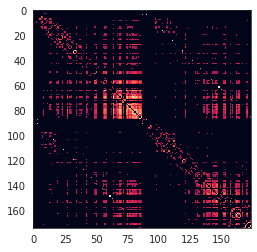

In [41]:
plt.imshow(a)

In [42]:
np.array_equal(np.isnan(gr_bold.run_deg[3, 1, 3]), np.abs(a).sum(0) == 0)

True

In [45]:
(np.abs(a).sum(0) == 0).sum(), np.isnan(gr_bold.run_deg[3, 1, 3]).sum()

(13, 13)

In [47]:
np.nanmax(gr_bold.run_deg), np.nanmin(gr_bold.run_deg)

(73.0, 1.0)

In [48]:
np.nanmax(gr_ca.run_deg), np.nanmin(gr_ca.run_deg)

(52.0, 1.0)

<AxesSubplot:ylabel='Count'>

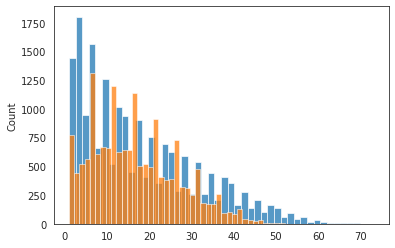

In [51]:
sns.histplot(gr_bold.run_deg[np.isfinite(gr_bold.run_deg)], color='C0')
sns.histplot(gr_ca.run_deg[np.isfinite(gr_ca.run_deg)], color='C1')

In [52]:
174 / 50

3.48

## Check how many are done

In [61]:
lfr_results = pjoin(lfr_dir, 'results')
len(os.listdir(lfr_results))

2320

In [62]:
done = []
pending = []

for item in os.listdir(lfr_results):
    path = pjoin(lfr_results, item)
    
    seeds = []
    for x in os.listdir(path):
        s = [s for s in x.split('-') if 'seed' in s]
        if s:
            s = s.pop()
            s = re.findall(r'\d+', s)
            s = int(s.pop())
            seeds.append(s)
    if set(np.arange(1, 101)).difference(seeds):
        pending.append(item)
    else:
        done.append(item)

len(done), len(pending)

(2048, 272)